In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
merged_df = pd.read_csv('/content/drive/MyDrive/MADS Capstone Team 23/Data/processed/merged_population_crime_homepermit.csv')

In [4]:
merged_df.columns

Index(['City', 'Date', 'ZHVI', 'NewHomePermits', 'Population_In_Housing_Units',
       'Owner_Occupied_Population', 'Renter-Occupied-Population',
       'OOP_Moved_From_Different_County', 'OOP_Moved_From_Different_State',
       'OOP_Moved_From_Abroad', 'ROP_Moved_From_Different_County',
       'ROP_Moved_From_Different_State', 'ROP_Moved_From_Abroad',
       'PropertyCrimeIncident', 'ViolentCrimeIncident'],
      dtype='object')

## Test If Less feature gives better performance

In [19]:
mse_results_with_more_features = {
    "Chicago":438524896.00,
    "Dallas": 5695424993.75,
    "Los Angeles": 118862908150.16,
    "New York": 8119322944.72,
    "Seattle": 42481872419.60
}

mse_result_mean_baseline = {
    "Chicago":24207704.96397773,
    "Dallas":103053946.00059289,
    "Los Angeles":377293240.89948076,
    "New York":76662955.16487668,
    "Seattle":492230546.0705847
}

In [6]:
# Function to process the data
def preprocess_data(df, window=12):
    # Separate train and test data (80% train, 20% test)
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    # Create sequences of 12 months for training
    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Function to create and train LSTM
def create_and_train_lstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

In [7]:
fewer_df = merged_df.drop(columns=['OOP_Moved_From_Different_County', 'OOP_Moved_From_Different_State',
       'OOP_Moved_From_Abroad', 'ROP_Moved_From_Different_County',
       'ROP_Moved_From_Different_State', 'ROP_Moved_From_Abroad'])

In [8]:
fewer_df.head()

,City,Date,ZHVI,NewHomePermits,Population_In_Housing_Units,Owner_Occupied_Population,Renter-Occupied-Population,PropertyCrimeIncident,ViolentCrimeIncident
0,Chicago,2010-01-01,201888.606600,345.0,9206524,6353379,2853145,14429.0,8335.0
1,Chicago,2010-02-01,201527.551140,370.0,9208651,6351028,2857623,11584.0,7056.0
2,Chicago,2010-03-01,200518.003420,561.0,9210778,6348678,2862100,15265.0,9819.0
3,Chicago,2010-04-01,200674.643669,543.0,9212906,6346328,2866578,15354.0,9834.0
4,Chicago,2010-05-01,200205.154396,924.0,9215033,6343977,2871056,16297.0,10654.0


In [ ]:
X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}
scalers = {}
models = {}
lstm_preds = {}
actual_vals = {}
mse_results_with_fewer_features = {}

for city in fewer_df['City'].unique():
    city_data = fewer_df[fewer_df['City'] == city].reset_index(drop=True)
    X_train_dict[city], y_train_dict[city], X_test_dict[city], y_test_dict[city], scalers[city] = preprocess_data(city_data)
    models[city] = create_and_train_lstm(X_train_dict[city], y_train_dict[city])
    lstm_preds[city] = make_predictions(models[city], X_test_dict[city], scalers[city])
    actual_vals[city] = scalers[city].inverse_transform(np.hstack((y_test_dict[city].reshape(-1, 1), np.zeros((y_test_dict[city].shape[0], X_test_dict[city].shape[2] - 1)))))
    actual_vals[city] = actual_vals[city][:, 0]  # Only return the ZHVI actuals
    mse = mean_squared_error(actual_vals[city], lstm_preds[city])
    mse_results_with_fewer_features[city] = mse
    print(f'{city} - LSTM Model MSE: {mse:.2f}')

Epoch 1/100
3/3 [==============================] - 13s 754ms/step - loss: 0.1859 - val_loss: 0.4378
Epoch 2/100
3/3 [==============================] - 0s 34ms/step - loss: 0.0611 - val_loss: 0.1744
Epoch 3/100
3/3 [==============================] - 0s 48ms/step - loss: 0.0672 - val_loss: 0.1329
Epoch 4/100
3/3 [==============================] - 0s 36ms/step - loss: 0.0573 - val_loss: 0.1767
Epoch 5/100
3/3 [==============================] - 0s 35ms/step - loss: 0.0355 - val_loss: 0.2402
Epoch 6/100
3/3 [==============================] - 0s 44ms/step - loss: 0.0313 - val_loss: 0.2619
Epoch 7/100
3/3 [==============================] - 0s 37ms/step - loss: 0.0285 - val_loss: 0.2075
Epoch 8/100
3/3 [==============================] - 0s 33ms/step - loss: 0.0171 - val_loss: 0.1140
Epoch 9/100
3/3 [==============================] - 0s 41ms/step - loss: 0.0090 - val_loss: 0.0464
Epoch 10/100
3/3 [==============================] - 0s 35ms/step - loss: 0.0082 - val_loss: 0.0253
Epoch 11/100
3/3 

1/1 [==============================] - 1s 1s/step
Chicago - LSTM Model MSE: 237474074.98
Epoch 1/100
3/3 [==============================] - 7s 593ms/step - loss: 0.0364 - val_loss: 0.0123
Epoch 2/100
3/3 [==============================] - 0s 47ms/step - loss: 0.0175 - val_loss: 0.0012
Epoch 3/100
3/3 [==============================] - 0s 41ms/step - loss: 0.0037 - val_loss: 0.0338
Epoch 4/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0076 - val_loss: 0.0343
Epoch 5/100
3/3 [==============================] - 0s 39ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 6/100
3/3 [==============================] - 0s 39ms/step - loss: 0.0021 - val_loss: 3.6567e-04
Epoch 7/100
3/3 [==============================] - 0s 45ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 8/100
3/3 [==============================] - 0s 47ms/step - loss: 8.7542e-04 - val_loss: 0.0218
Epoch 9/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0014 - val_loss: 0.0252
Epoch 10/100
3/3 [==

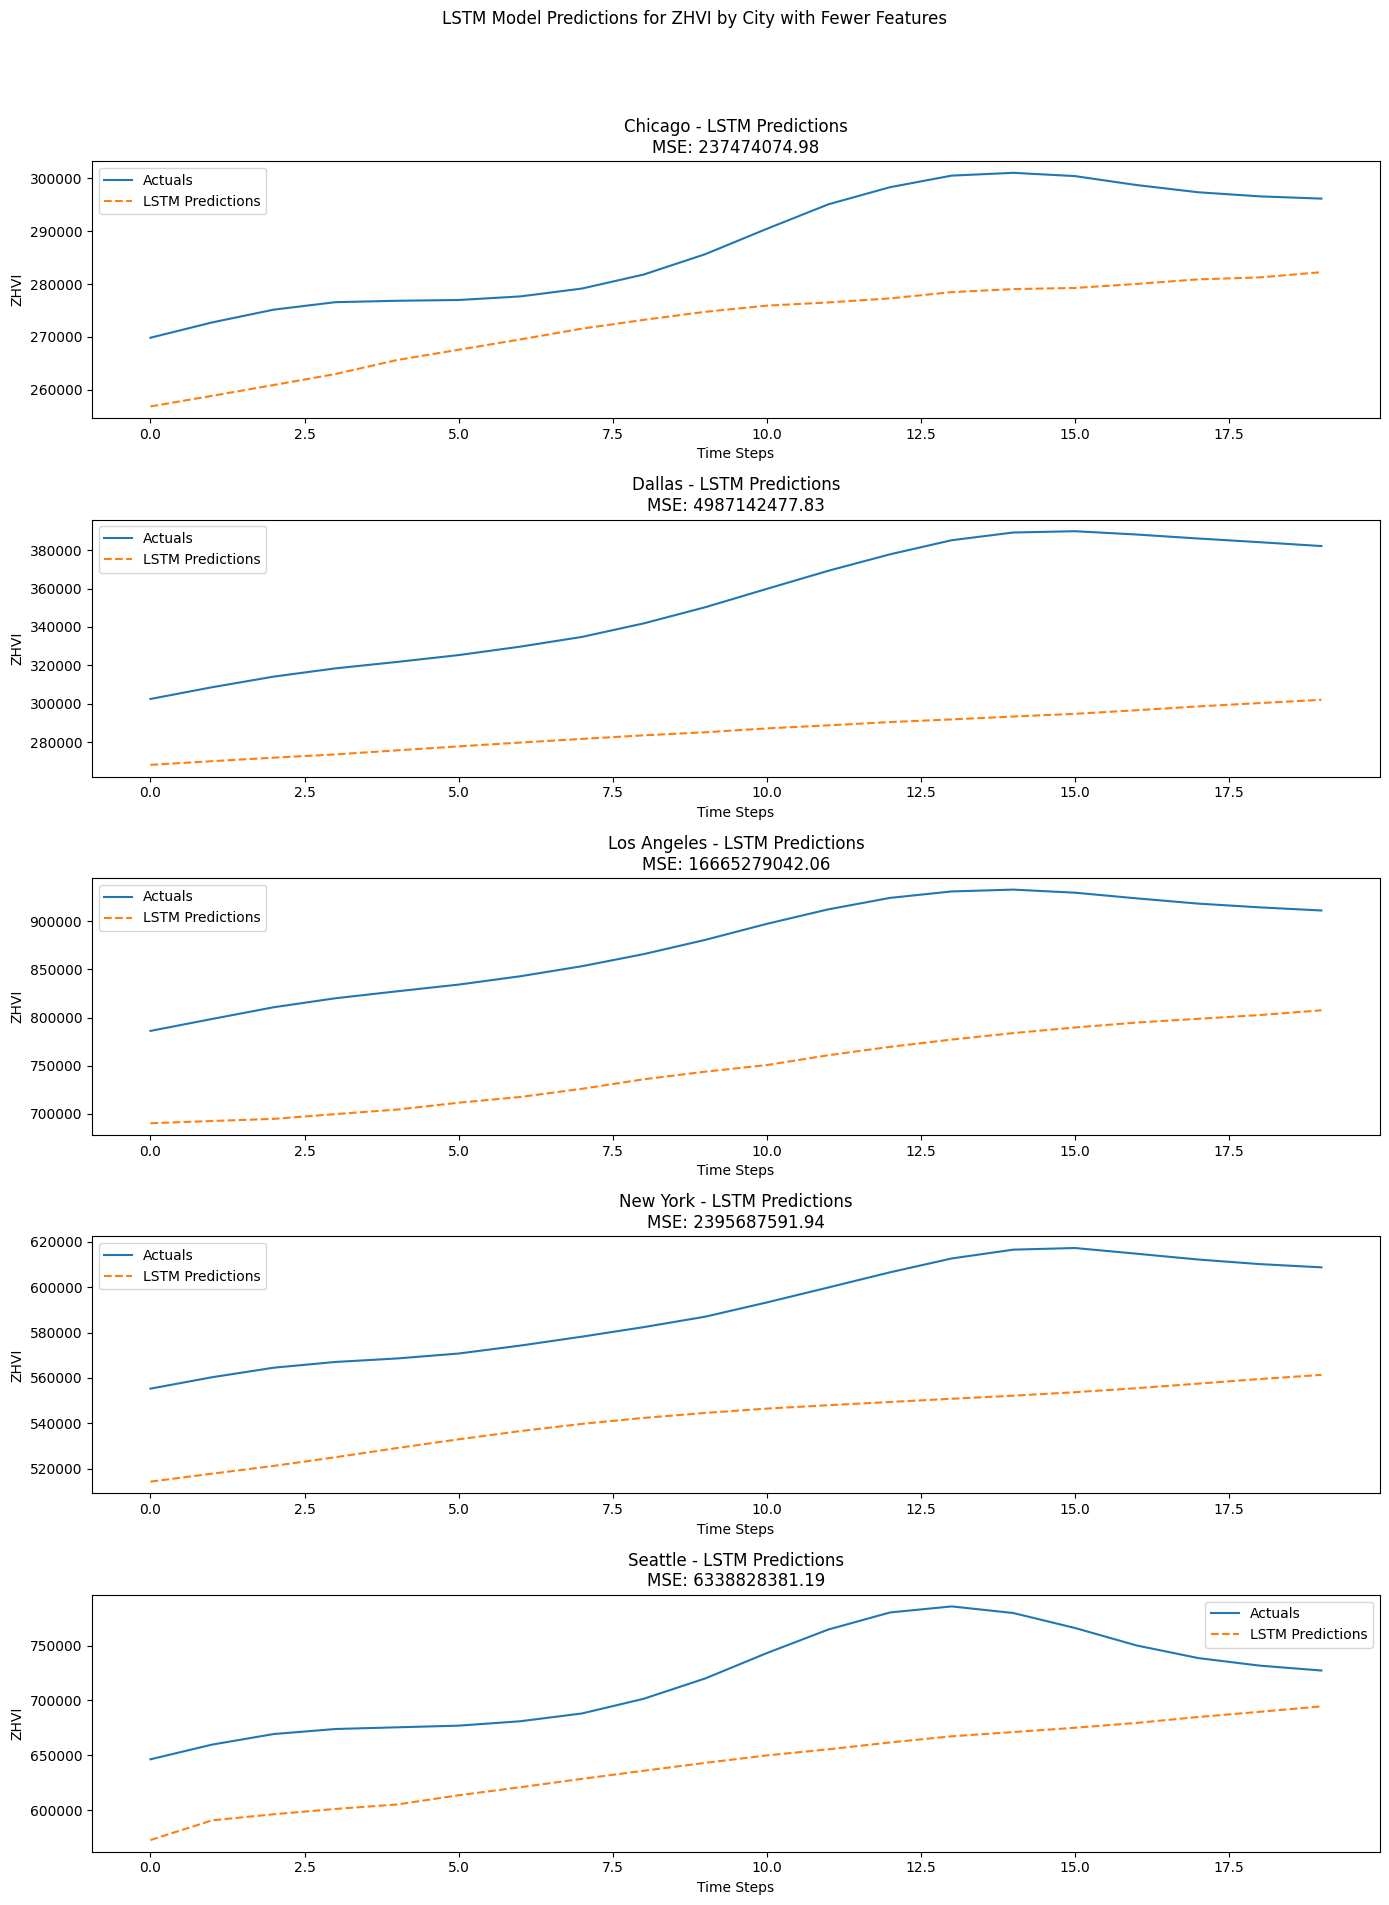

In [ ]:
# Plotting the results for each city
fig, axs = plt.subplots(len(fewer_df['City'].unique()), 1, figsize=(14, 20))
fig.suptitle('LSTM Model Predictions for ZHVI by City with Fewer Features')

for idx, city in enumerate(fewer_df['City'].unique()):
    axs[idx].plot(actual_vals[city], label='Actuals')
    axs[idx].plot(lstm_preds[city], label='LSTM Predictions', linestyle='--')
    axs[idx].set_title(f'{city} - LSTM Predictions\nMSE: {mse_results_with_fewer_features[city]:.2f}')
    axs[idx].set_xlabel('Time Steps')
    axs[idx].set_ylabel('ZHVI')
    axs[idx].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
comparison_dict = {}
for city in mse_results_with_fewer_features.keys():
  percent_change = ((mse_results_with_fewer_features[city] - mse_results_with_more_features[city])/mse_results_with_more_features[city])*100
  comparison_dict[city] = percent_change
  print(f"For {city}, the model with fewer features performed {'better' if percent_change < 0 else 'worse'} by {abs(percent_change):.2f}%")

print("\nSummary of Performance Changes:")
print(comparison_dict)

For Chicago, the model with fewer features performed better by 45.85%
For Dallas, the model with fewer features performed better by 12.44%
For Los Angeles, the model with fewer features performed better by 85.98%
For New York, the model with fewer features performed better by 70.49%
For Seattle, the model with fewer features performed better by 85.08%

Summary of Performance Changes:
{'Chicago': -45.84707113584807, 'Dallas': -12.435990583546884, 'Los Angeles': -85.97941165884153, 'New York': -70.49399798170589, 'Seattle': -85.07874530910794}


# <h1><center>Test Different Sequence Length</center></h1>

In [9]:
# Use fewer df as we know it performs better
fewer_df = merged_df.drop(columns=['OOP_Moved_From_Different_County', 'OOP_Moved_From_Different_State',
       'OOP_Moved_From_Abroad', 'ROP_Moved_From_Different_County',
       'ROP_Moved_From_Different_State', 'ROP_Moved_From_Abroad'])

In [10]:
# Function to preprocess data for LSTM
def preprocess_data(df, window):
    # Separate train and test data (80% train, 20% test)
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    # Create sequences of specified length for training
    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Function to create and train LSTM model
def create_and_train_lstm(X_train, y_train, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions


In [11]:
# Define sequence lengths to test
sequence_lengths = [1, 3, 6, 9, 12, 15]

# Initialize dictionaries to store results
results = {}

# Loop through each city and each sequence length
for city in fewer_df['City'].unique():
    city_data = fewer_df[fewer_df['City'] == city].reset_index(drop=True)
    results[city] = {}

    for seq_len in sequence_lengths:
        X_train, y_train, X_test, y_test, scaler = preprocess_data(city_data, window=seq_len)

        # Train the model
        model = create_and_train_lstm(X_train, y_train)

        # Make predictions
        lstm_preds = make_predictions(model, X_test, scaler)
        actual_vals = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
        actual_vals = actual_vals[:, 0]

        # Calculate MSE
        mse = mean_squared_error(actual_vals, lstm_preds)
        results[city][seq_len] = {'mse': mse, 'predictions': lstm_preds, 'actuals': actual_vals}
        print(f'{city} - Sequence Length {seq_len} - MSE: {mse:.2f}')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - loss: 0.1811 - val_loss: 0.7822
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1480 - val_loss: 0.7349
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1385 - val_loss: 0.6842
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1210 - val_loss: 0.6298
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1079 - val_loss: 0.5694
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0846 - val_loss: 0.5033
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0691 - val_loss: 0.4372
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0609 - val_loss: 0.3802
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0554 - val_loss: 0.3325
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0525 - val_loss: 0.2904
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0548 - val_loss: 0.2628
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0488 - val_loss: 0.2596
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - loss: 0.1691 - val_loss: 0.7058
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1218 - val_loss: 0.5746
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0879 - val_loss: 0.4469
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0617 - val_loss: 0.3340
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0572 - val_loss: 0.2606
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0622 - val_loss: 0.2341
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0483 - val_loss: 0.2321
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0455 - val_loss: 0.2427
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0423 - val_loss: 0.2475
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0368 - val_loss: 0.2383
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0368 - val_loss: 0.2077
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0329 - val_loss: 0.1615
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - loss: 0.1782 - val_loss: 0.5737
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0868 - val_loss: 0.3450
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0645 - val_loss: 0.2377
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0707 - val_loss: 0.2299
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0537 - val_loss: 0.2721
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0457 - val_loss: 0.3038
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0439 - val_loss: 0.3101
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0381 - val_loss: 0.2737
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0327 - val_loss: 0.2011
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0253 - val_loss: 0.1211
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0186 - val_loss: 0.0785
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0121 - val_loss: 0.0561
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.3016 - val_loss: 0.5000
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0943 - val_loss: 0.2455
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0544 - val_loss: 0.1218
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0804 - val_loss: 0.1350
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0554 - val_loss: 0.1926
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0391 - val_loss: 0.2544
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0344 - val_loss: 0.2782
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0307 - val_loss: 0.2590
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0307 - val_loss: 0.2012
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0202 - val_loss: 0.1302
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0147 - val_loss: 0.0747
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0129 - val_loss: 0.0474
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - loss: 0.1501 - val_loss: 0.3118
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0659 - val_loss: 0.1422
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0601 - val_loss: 0.1418
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0359 - val_loss: 0.1843
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0216 - val_loss: 0.1629
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0166 - val_loss: 0.0677
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0073 - val_loss: 7.5687e-04
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0048 - val_loss: 6.9312e-04
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0026 - val_loss: 0.0063
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0026 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Chicago - Sequence Length 12 - MSE: 514697372.45
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - loss: 0.1411 - val_loss: 0.2424
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0626 - val_loss: 0.1458
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0419 - val_loss: 0.1776
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0255 - val_loss: 0.1587
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0167 - val_loss: 0.0607
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0088 - val_loss: 0.0032
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0059 - val_loss: 0.0098
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0070 - val_loss: 0.0028
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0029 - val_loss: 6.7717e-04
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Chicago - Sequence Length 15 - MSE: 240093454.04
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.1309 - val_loss: 0.7751
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1304 - val_loss: 0.7013
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1016 - val_loss: 0.6236
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0908 - val_loss: 0.5400
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0674 - val_loss: 0.4537
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0676 - val_loss: 0.3612
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0433 - val_loss: 0.2738
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0394 - val_loss: 0.1957
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0335 - val_loss: 0.1464
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0301 - val_loss: 0.1223
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0276 - val_loss: 0.1076
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0234 - val_loss: 0.0877
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - loss: 0.0934 - val_loss: 0.5157
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0736 - val_loss: 0.3373
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0425 - val_loss: 0.1871
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0240 - val_loss: 0.0834
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0224 - val_loss: 0.0372
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0204 - val_loss: 0.0293
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0164 - val_loss: 0.0419
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0095 - val_loss: 0.0642
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0062 - val_loss: 0.0756
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0051 - val_loss: 0.0714
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0038 - val_loss: 0.0529
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029 - val_loss: 0.0278
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - loss: 0.0725 - val_loss: 0.1576
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0239 - val_loss: 0.0247
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0240 - val_loss: 0.0217
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0110 - val_loss: 0.0527
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0051 - val_loss: 0.0781
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0061 - val_loss: 0.0583
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0034 - val_loss: 0.0207
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0032 - val_loss: 0.0153
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0019 - val_loss: 0.0270
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0024 - val_loss: 0.0237
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 648ms/step - loss: 0.1488 - val_loss: 0.4063
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0577 - val_loss: 0.1110
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0287 - val_loss: 0.0155
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0262 - val_loss: 0.0134
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0122 - val_loss: 0.0455
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0039 - val_loss: 0.0730
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0073 - val_loss: 0.0478
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0048 - val_loss: 0.0140
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0029 - val_loss: 0.0059
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0042 - val_loss: 0.0073
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0017 - val_loss: 0.0202
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0012 - val_loss: 0.0296
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.1668 - val_loss: 0.2664
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0489 - val_loss: 0.0206
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0311 - val_loss: 0.0012
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0175 - val_loss: 0.0115
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0021 - val_loss: 0.0337
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0054 - val_loss: 0.0270
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0031 - val_loss: 7.7651e-04
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0035 - val_loss: 6.0516e-04
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0020 - val_loss: 0.0095
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.3905e-04 - val_loss: 0.0255
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0014 - val_loss: 0.0303

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - loss: 0.0879 - val_loss: 0.1105
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0311 - val_loss: 0.0328
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0194 - val_loss: 0.0523
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0055 - val_loss: 0.0691
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0048 - val_loss: 0.0265
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0034 - val_loss: 0.0231
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0023 - val_loss: 0.0296
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0015 - val_loss: 0.0135
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0012 - val_loss: 0.0074
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0015 - val_loss: 0.0123
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 377ms/step - loss: 0.1699 - val_loss: 0.8080
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1409 - val_loss: 0.7428
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1367 - val_loss: 0.6756
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1033 - val_loss: 0.6085
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0845 - val_loss: 0.5342
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0701 - val_loss: 0.4534
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0531 - val_loss: 0.3740
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0380 - val_loss: 0.2911
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0247 - val_loss: 0.2176
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0202 - val_loss: 0.1711
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0204 - val_loss: 0.1466
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0198 - val_loss: 0.1376
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - loss: 0.1442 - val_loss: 0.6557
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0867 - val_loss: 0.5080
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0581 - val_loss: 0.3693
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0287 - val_loss: 0.2474
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0216 - val_loss: 0.1559
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0272 - val_loss: 0.1165
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0286 - val_loss: 0.1225
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0242 - val_loss: 0.1556
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0184 - val_loss: 0.1888
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0185 - val_loss: 0.2134
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0183 - val_loss: 0.2181
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0155 - val_loss: 0.2015
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.1598 - val_loss: 0.5550
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0690 - val_loss: 0.3059
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0237 - val_loss: 0.1282
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0252 - val_loss: 0.0701
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0340 - val_loss: 0.0877
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0222 - val_loss: 0.1407
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0163 - val_loss: 0.1906
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0181 - val_loss: 0.2163
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0185 - val_loss: 0.2060
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0160 - val_loss: 0.1691
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0123 - val_loss: 0.1249
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0091 - val_loss: 0.0879
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - loss: 0.2030 - val_loss: 0.5913
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0699 - val_loss: 0.2213
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0212 - val_loss: 0.0502
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0427 - val_loss: 0.0491
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0307 - val_loss: 0.1046
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0153 - val_loss: 0.1708
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0157 - val_loss: 0.2033
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0178 - val_loss: 0.1915
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0147 - val_loss: 0.1501
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0108 - val_loss: 0.0995
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0084 - val_loss: 0.0620
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0092 - val_loss: 0.0486
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - loss: 0.1348 - val_loss: 0.3303
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0286 - val_loss: 0.0892
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0488 - val_loss: 0.0994
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0291 - val_loss: 0.1878
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0183 - val_loss: 0.2424
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0230 - val_loss: 0.2151
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0165 - val_loss: 0.1486
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0107 - val_loss: 0.0802
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0103 - val_loss: 0.0495
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0099 - val_loss: 0.0600
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0052 - val_loss: 0.0854
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0055 - val_loss: 0.0835
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - loss: 0.3009 - val_loss: 0.3691
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0336 - val_loss: 0.0358
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0536 - val_loss: 0.0215
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0444 - val_loss: 0.0868
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0149 - val_loss: 0.1708
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0214 - val_loss: 0.2033
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0245 - val_loss: 0.1697
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0163 - val_loss: 0.1031
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0099 - val_loss: 0.0435
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0088 - val_loss: 0.0205
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0103 - val_loss: 0.0220
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0056 - val_loss: 0.0368
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.1024 - val_loss: 0.7068
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0856 - val_loss: 0.6585
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0661 - val_loss: 0.6105
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0619 - val_loss: 0.5610
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0546 - val_loss: 0.5072
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0359 - val_loss: 0.4496
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0370 - val_loss: 0.3920
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0351 - val_loss: 0.3477
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0331 - val_loss: 0.3317
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0341 - val_loss: 0.3347
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0319 - val_loss: 0.3309
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0312 - val_loss: 0.3362
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 379ms/step - loss: 0.0881 - val_loss: 0.6062
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0541 - val_loss: 0.4936
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0402 - val_loss: 0.3888
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0267 - val_loss: 0.3109
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0306 - val_loss: 0.2797
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0296 - val_loss: 0.2816
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0228 - val_loss: 0.3032
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0192 - val_loss: 0.3279
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0183 - val_loss: 0.3319
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0161 - val_loss: 0.3207
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0144 - val_loss: 0.2896
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0106 - val_loss: 0.2538


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step - loss: 0.1049 - val_loss: 0.4449
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0375 - val_loss: 0.2445
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0337 - val_loss: 0.1849
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0341 - val_loss: 0.2156
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0194 - val_loss: 0.2610
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0146 - val_loss: 0.2767
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0141 - val_loss: 0.2409
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0090 - val_loss: 0.1746
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0060 - val_loss: 0.1154
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0066 - val_loss: 0.0973
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0048 - val_loss: 0.1027
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0035 - val_loss: 0.1004
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.1019 - val_loss: 0.4362
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0381 - val_loss: 0.3094
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0430 - val_loss: 0.3161
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0281 - val_loss: 0.3678
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0214 - val_loss: 0.3794
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0177 - val_loss: 0.3381
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0107 - val_loss: 0.2693
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0095 - val_loss: 0.2294
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0082 - val_loss: 0.2382
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0086 - val_loss: 0.2293
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0079 - val_loss: 0.1721
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0066 - val_loss: 0.1449
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - loss: 0.1065 - val_loss: 0.3524
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0422 - val_loss: 0.2425
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0415 - val_loss: 0.3207
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0242 - val_loss: 0.4088
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0210 - val_loss: 0.3942
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0177 - val_loss: 0.2972
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0080 - val_loss: 0.2030
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0090 - val_loss: 0.1639
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0081 - val_loss: 0.1710
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0048 - val_loss: 0.1639
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0045 - val_loss: 0.1237
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0026 - val_loss: 0.0759
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - loss: 0.0816 - val_loss: 0.2223
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0503 - val_loss: 0.2548
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0292 - val_loss: 0.3909
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0259 - val_loss: 0.3653
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0173 - val_loss: 0.2431
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0090 - val_loss: 0.1675
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0106 - val_loss: 0.1808
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0050 - val_loss: 0.1962
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0068 - val_loss: 0.1406
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0031 - val_loss: 0.0931
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0035 - val_loss: 0.0924
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0019 - val_loss: 0.0941
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.1269 - val_loss: 0.7619
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1214 - val_loss: 0.6882
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0951 - val_loss: 0.6137
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0886 - val_loss: 0.5353
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0689 - val_loss: 0.4535
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0485 - val_loss: 0.3636
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0367 - val_loss: 0.2745
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0279 - val_loss: 0.1990
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0241 - val_loss: 0.1376
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0217 - val_loss: 0.1004
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0219 - val_loss: 0.0757
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0219 - val_loss: 0.0779


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 0.1312 - val_loss: 0.6243
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0866 - val_loss: 0.4406
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0469 - val_loss: 0.2740
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0270 - val_loss: 0.1352
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0195 - val_loss: 0.0506
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0238 - val_loss: 0.0266
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0233 - val_loss: 0.0360
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0182 - val_loss: 0.0641
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0140 - val_loss: 0.0959
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0122 - val_loss: 0.1131
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0130 - val_loss: 0.1049
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0118 - val_loss: 0.0789
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - loss: 0.1789 - val_loss: 0.6593
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0885 - val_loss: 0.3401
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0391 - val_loss: 0.1285
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0298 - val_loss: 0.0428
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0352 - val_loss: 0.0356
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0292 - val_loss: 0.0580
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0206 - val_loss: 0.0888
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0128 - val_loss: 0.1029
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0116 - val_loss: 0.0883
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0105 - val_loss: 0.0490
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0057 - val_loss: 0.0151
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - loss: 0.0586 - val_loss: 0.1158
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0208 - val_loss: 0.0166
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0217 - val_loss: 0.0353
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0096 - val_loss: 0.0808
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0097 - val_loss: 0.0859
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0090 - val_loss: 0.0330
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - loss: 0.1615 - val_loss: 0.3188
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0373 - val_loss: 0.0399
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0272 - val_loss: 0.0044
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0324 - val_loss: 0.0218
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0165 - val_loss: 0.0662
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0108 - val_loss: 0.0903
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0130 - val_loss: 0.0666
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0088 - val_loss: 0.0225
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0028 - val_loss: 0.0098
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0031 - val_loss: 0.0077
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.2034e-04 - val_loss: 0.0023
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - loss: 0.1526 - val_loss: 0.2354
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0298 - val_loss: 0.0159
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0410 - val_loss: 0.0209
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0204 - val_loss: 0.0760
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0161 - val_loss: 0.1008
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0158 - val_loss: 0.0400
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0039 - val_loss: 0.0153
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0014 - val_loss: 0.0153
Epoch 13/50

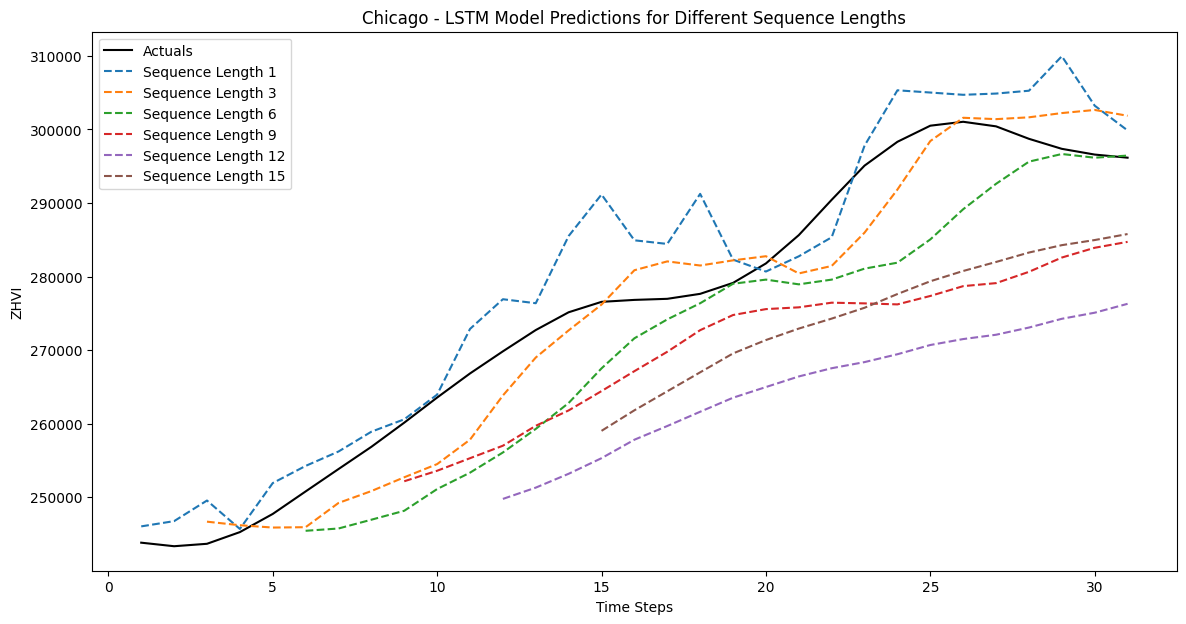

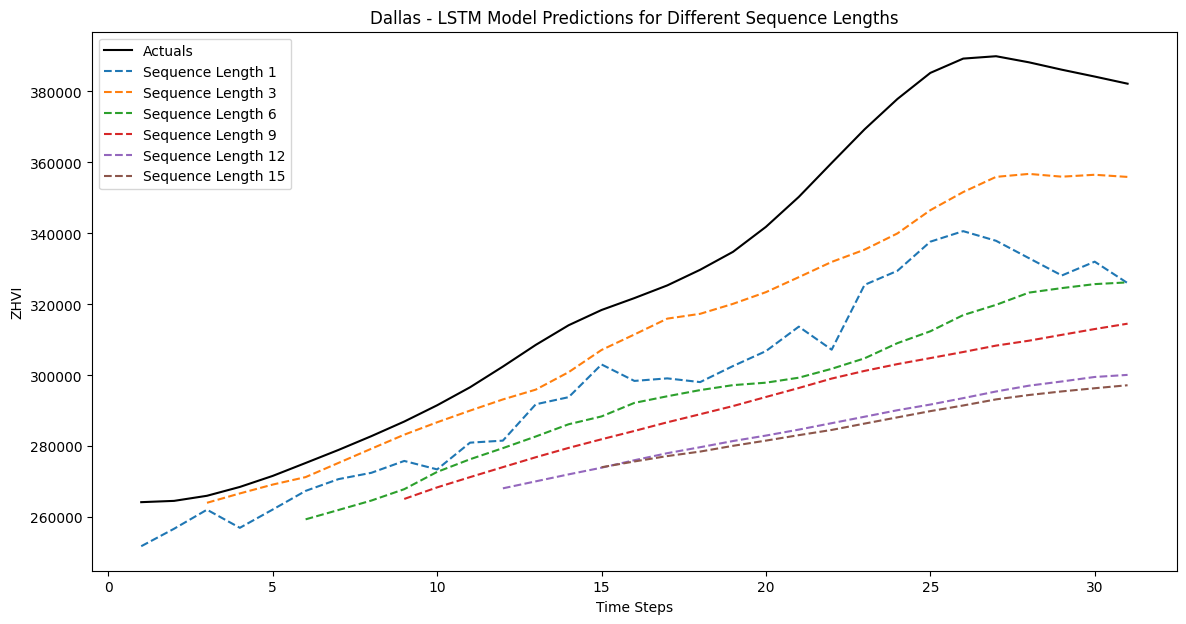

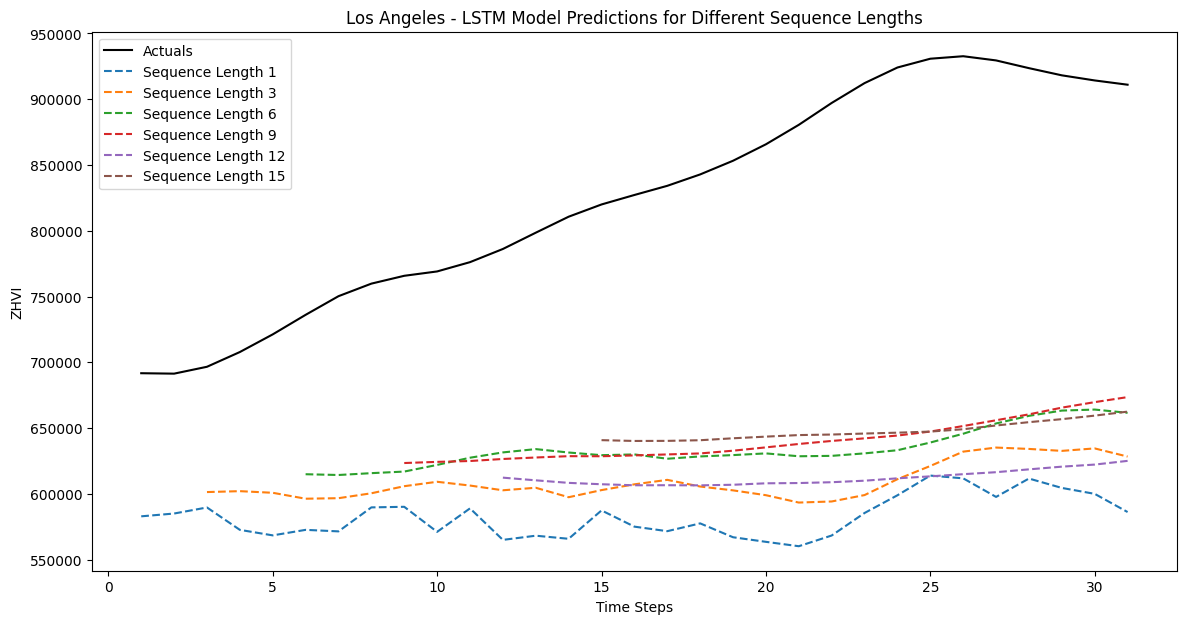

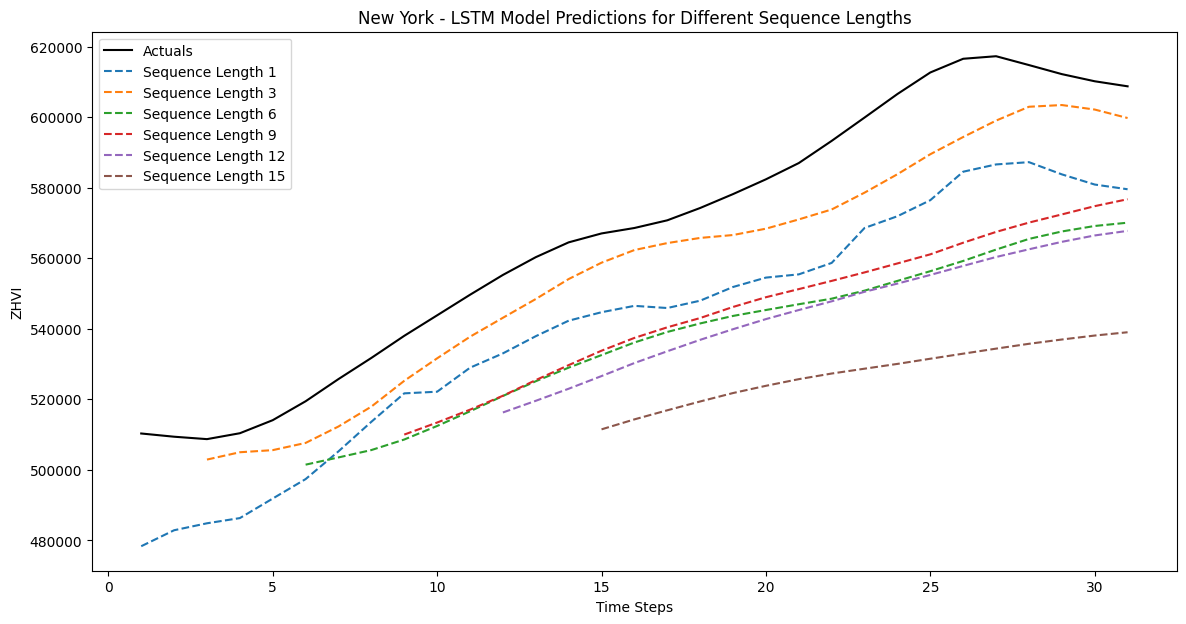

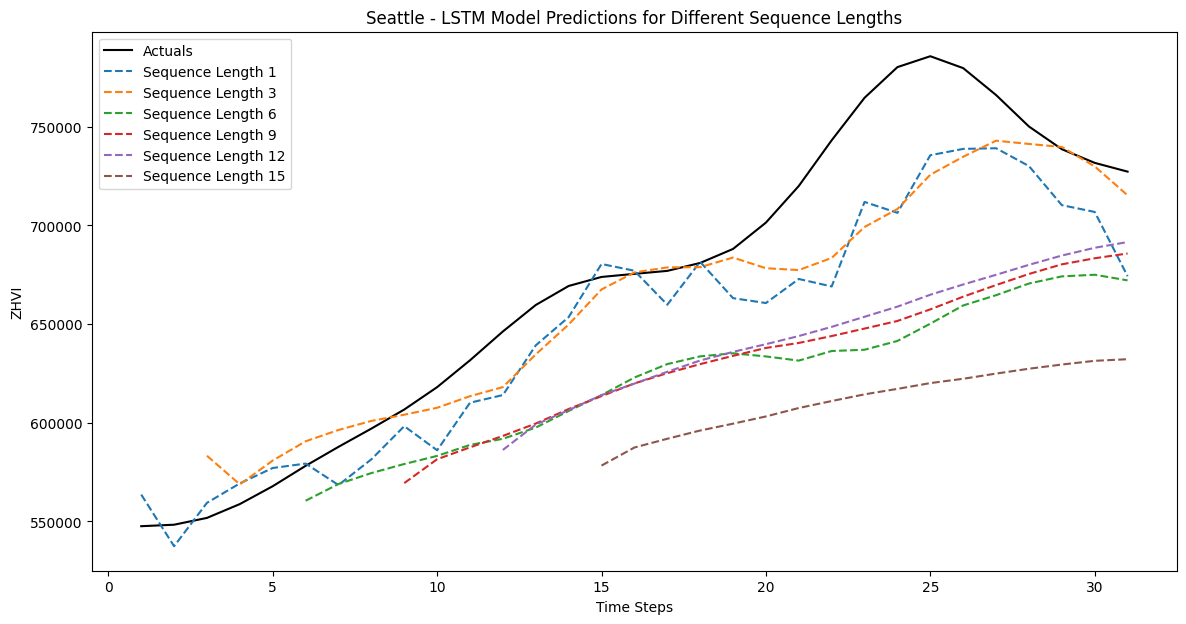

In [13]:
# Plotting the results for each city
for city in fewer_df['City'].unique():
    plt.figure(figsize=(14, 7))
    plt.title(f'{city} - LSTM Model Predictions for Different Sequence Lengths')
    actuals_plotted = False
    for seq_len in sequence_lengths:
        if not actuals_plotted:
            plt.plot(range(seq_len, seq_len + len(results[city][seq_len]['actuals'])), results[city][seq_len]['actuals'], label='Actuals', color='black')
            actuals_plotted = True
        plt.plot(range(seq_len, seq_len + len(results[city][seq_len]['predictions'])), results[city][seq_len]['predictions'], label=f'Sequence Length {seq_len}', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('ZHVI')
    plt.legend()
    plt.show()

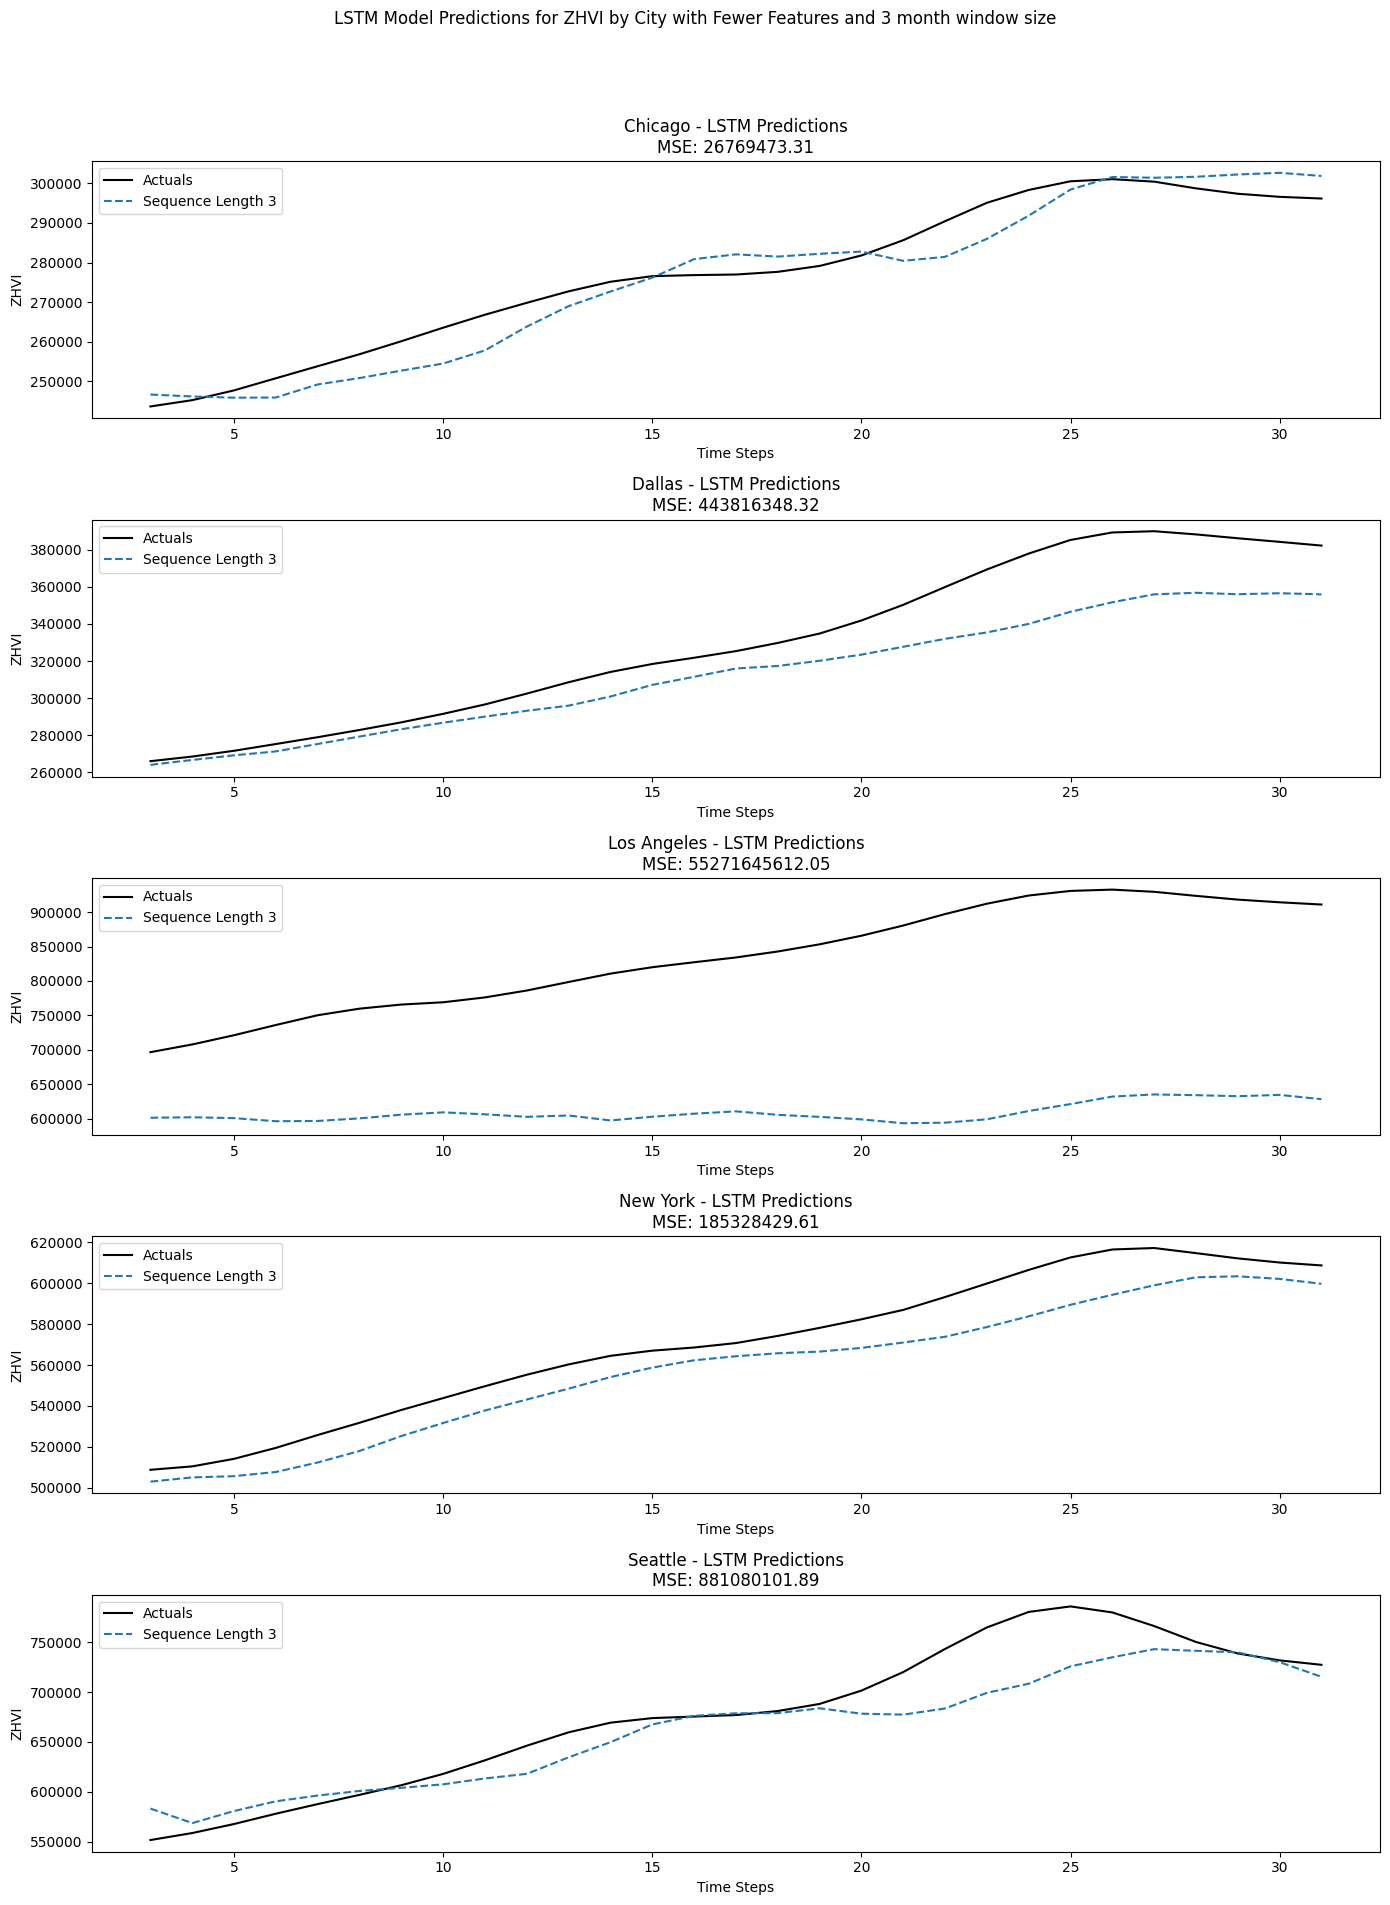

In [16]:
# Plotting the results for each city
fig, axs = plt.subplots(len(fewer_df['City'].unique()), 1, figsize=(14, 20))
fig.suptitle('LSTM Model Predictions for ZHVI by City with Fewer Features and 3 month window size')
seq_len = 3

for idx, city in enumerate(fewer_df['City'].unique()):
    axs[idx].plot(range(seq_len, seq_len + len(results[city][seq_len]['actuals'])), results[city][seq_len]['actuals'], label='Actuals', color='black')
    axs[idx].plot(range(seq_len, seq_len + len(results[city][seq_len]['predictions'])), results[city][seq_len]['predictions'], label=f'Sequence Length {seq_len}', linestyle='--')
    city_mse = results[city][seq_len]['mse']
    axs[idx].set_title(f'{city} - LSTM Predictions\nMSE: {city_mse:.2f}')
    axs[idx].set_xlabel('Time Steps')
    axs[idx].set_ylabel('ZHVI')
    axs[idx].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [20]:
# Comapre the MSE of 3 month windows size with mean baseline model

comparison_dict = {}
for city in mse_result_mean_baseline.keys():
  city_mse = results[city][seq_len]['mse']
  percent_change = ((city_mse - mse_result_mean_baseline[city])/mse_result_mean_baseline[city])*100
  comparison_dict[city] = percent_change
  print(f"For {city}, the model with fewer features and 3 month window size performed {'better' if percent_change < 0 else 'worse'} by {abs(percent_change):.2f}%")

print("\nSummary of Performance Changes Comparing to Mean Baseline Model:")
print(comparison_dict)

For Chicago, the model with fewer features and 3 month window size performed worse by 10.58%
For Dallas, the model with fewer features and 3 month window size performed worse by 330.66%
For Los Angeles, the model with fewer features and 3 month window size performed worse by 14549.52%
For New York, the model with fewer features and 3 month window size performed worse by 141.74%
For Seattle, the model with fewer features and 3 month window size performed worse by 79.00%

Summary of Performance Changes Comparing to Mean Baseline Model:
{'Chicago': 10.582450302862723, 'Dallas': 330.66409928416533, 'Los Angeles': 14549.519159230764, 'New York': 141.74443734010964, 'Seattle': 78.99744518532873}


In [ ]:
# TODO:
# Try em interpolation for better data estimation
# Add other features in
# Try out other hyper parameters